<a href="https://colab.research.google.com/github/dlz01/Big-Data-2024-Project/blob/main/remove_outlier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# reference https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=f28fb5ca7c8450a489e7d61fc0ca65079aa3700a
# data https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import heapq
from scipy.spatial.distance import euclidean

## Setup

In [3]:
def MBR_endpoints(cluster):
  sigma = len(cluster[0])
  r_min = []
  r_max = []
  for i in range(sigma):
    max_coord = float('-inf')
    min_coord = float('inf')
    for point in cluster:
      min_coord = min(min_coord, point[i])
      max_coord = max(max_coord, point[i])
    r_min.append(min_coord)
    r_max.append(max_coord)
  return r_min, r_max

In [4]:
def MINDIST(R, S):
  r_min, r_max = MBR_endpoints(R)
  s_min, s_max = MBR_endpoints(S)
  sigma = len(r_min)
  x = 0
  for i in range(sigma):
    if s_max[i]<r_min[i]:
      xi = r_min[i]-s_max[i]
    elif r_max[i]<s_min[i]:
      xi =s_min[i]-r_max[i]
    else:
      xi = 0
    x += xi**2
  return x

In [5]:
def MAXDIST(R,S):
    r_min, r_max = MBR_endpoints(R)
    s_min, s_max = MBR_endpoints(S)
    sigma = len(r_min)
    x = 0
    for i in range(sigma):
      xi = max(abs(s_max[i]-r_min[i]), abs(r_max[i]-s_min[i]))
      x += xi**2
    return x

In [6]:
class Node:
    def __init__(self, data=None):
        self.data = data
        self.child = None
    def is_leaf(self, node):
        return node.child is None

class Tree:
    def __init__(self):
        self.root = None

    def insert(self, data):
        new_node = Node(data)
        if self.root is None:
            self.root = new_node
        else:
            self._insert_recursive(self.root, new_node)

    def _insert_recursive(self, current_node, new_node):
        if current_node.child is None:
            current_node.child = new_node
        else:
            self._insert_recursive(current_node.child, new_node)


class MaxHeap:
    def __init__(self):
        self.heap = []
    def push(self, arr, distance):
        heapq.heappush(self.heap, (distance*(-1), arr))
    def top(self):
        if self.heap:
            return self.heap[0][1]
    def top_points(self):
        if self.heap:
            return len(self.heap[0][1])
    def delete_top(self):
        if self.heap:
            return heapq.heappop(self.heap)[1]
    def top_distance(self):
      if self.heap:
          return (-1)*self.heap[0][0]
    def num_points(self):
        return sum(len(arr) for _, arr in self.heap)

class MinHeap:
    def __init__(self):
        self.heap = []
    def push(self, arr, distance):
        heapq.heappush(self.heap, (distance, arr))
    def top(self):
        if self.heap:
            return self.heap[0][1]
    def top_points(self):
        if self.heap:
            return len(self.heap[0][1])
    def delete_top(self):
        if self.heap:
            return heapq.heappop(self.heap)[1]
    def top_distance(self):
        if self.heap:
            return self.heap[0][0]
    def num_points(self):
        return sum(len(arr) for _, arr in self.heap)

class Partition:
    def __init__(self, points=None,upper=None, lower=None, neighbors=None):
        self.points = points
        self.upper = upper
        self.lower = lower
        self.neighbors = neighbors if neighbors is not None else []

class LinkedListNode:
    def __init__(self, data=None):
        self.data = data
        self.next = None

## Method

In [7]:
# Step1: Generate Partitions
def generate_partitions(data,n_clusters):
  clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
  clustering.fit(data)
  cluster_labels = clustering.labels_
  partitions = {}
  for i, label in enumerate(cluster_labels):
    if label not in partitions:
        partitions[label] = []
    partitions[label].append(data[i])
  combined_clusters = []
  for cluster in partitions.values():
    combined_clusters.append(cluster)
  return combined_clusters

In [8]:
# Step2: Bounds for D^k
def compute_lower_upper(Root, P, k, minDkDist):
  nodeList = [Root]
  P.lower = float('inf')
  P.upper = float('inf')
  lowerHeap = MaxHeap()
  upperHeap = MaxHeap()
  node = Root
  while node.is_leaf is False:
    nodeList.append(node.child)
    node = node.child
  while nodeList:
    node = nodeList[0]
    nodeList = nodeList[1:]
    if MINDIST(P.points, node.data) < P.lower:
      lowerHeap.push(node.data, MINDIST(P.points, node.data))
      while lowerHeap.num_points()-lowerHeap.top_points()>=k:
        lowerHeap.delete_top()
      if lowerHeap.num_points() >= k:
        P.lower = MINDIST(P.points, lowerHeap.top())
    if MAXDIST(P.points, node.data) < P.upper:
      upperHeap.push(node.data, MAXDIST(P.points, node.data))
      while upperHeap.num_points()-upperHeap.top_points() >= k:
            upperHeap.delete_top()
      if lowerHeap.num_points() >= k:
        P.upper = MAXDIST(P.points, upperHeap.top())
      if P.upper <= minDkDist:
        return
  return

In [9]:
# Step3: Candidate Partitions
def compute_candidate_partitions(PSet, k, n):
  tree = Tree()
  for P in PSet:
    tree.insert(P)
  partHeap = MinHeap()
  minDkDist = 0
  par_list = []
  for P in PSet:
    Par = Partition(points=P)
    par_list.append(Par)
    compute_lower_upper(tree.root, Par, k, minDkDist)
    if Par.lower > minDkDist:
            partHeap.push(P, Par.lower)
            while partHeap.num_points()-partHeap.top_points() >= n:
                partHeap.delete_top()
            if partHeap.num_points() >= n:
                minDkDist = partHeap.top_distance()

  candSet = []
  for P in par_list:
    if P.upper >= minDkDist:
      candSet.append(P)
      for Q in PSet:
        if MINDIST(P.points, Q) <= P.upper:
          P.neighbors.append(Q)
  return candSet

In [10]:
# Step4: Ourliers in Candidate Partitions
def getKthNeighborDist(neighbors,target_p,k,minDKDist):
    nearHeap = MaxHeap()
    DkDist = float('inf')
    for neighbor_par in neighbors:
      for neighbor_p in neighbor_par:
        if euclidean(target_p, neighbor_p)<DkDist:
          nearHeap.push(neighbor_p, euclidean(target_p, neighbor_p))
        if len(nearHeap.heap)>k:
            nearHeap.delete_top()
        if len(nearHeap.heap) == k:
            DkDist = nearHeap.top_distance()
        if DkDist<= minDKDist:
          return DkDist
    return DkDist



In [11]:
# Step4: Ourliers in Candidate Partitions
def compute_outlier_index(k,n,dataset):
  tree = Tree()
  for p in dataset:
    tree.insert(p)
  outHeap = MinHeap()
  minDkDist = 0
  for p in dataset:
    for target_p in p.points:
      DkDist = getKthNeighborDist(p.neighbors,target_p,k,minDkDist)
      if DkDist>minDkDist:
        outHeap.push(target_p, DkDist)
        if len(outHeap.heap)>n:
          outHeap.delete_top()
        if len(outHeap.heap)== n:
          minDkDist = outHeap.top_distance()
  return outHeap

In [13]:
# function
def remove_outliers(data, k, n,n_clusters):
  partitions = generate_partitions(data,n_clusters)
  print('partitions done')
  candSet = compute_candidate_partitions(partitions, k, n)
  print('candidate set done')
  outliers = compute_outlier_index(k,n,candSet)
  print('outliers done')
  outlier_list = []
  while outliers.heap:
    outlier_list.append(outliers.top())
    outliers.delete_top()
  for outlier in outlier_list:
    if outlier in data:
      data.remove(outlier)
  return data

## EDA

In [43]:
df = pd.read_excel('green_tripdata_2024-01.xlsx')
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1,236,239,1,1.98,12.8,1.0,0.5,3.61,0.0,NaN,1,21.66,1,1,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1,65,170,5,6.54,30.3,1.0,0.5,7.11,0.0,NaN,1,42.66,1,1,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1,74,262,1,3.08,19.8,1.0,0.5,3.00,0.0,NaN,1,28.05,1,1,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1,74,116,1,2.40,14.2,1.0,1.5,0.00,0.0,NaN,1,16.70,2,1,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1,74,243,1,5.14,22.6,1.0,0.5,6.28,0.0,NaN,1,31.38,1,1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,2024-01-01 20:55:13,2024-01-01 21:06:25,N,1,74,141,1,3.06,14.9,1.0,0.5,3.02,0.0,NaN,1,23.17,1,1,2.75
996,2,2024-01-01 20:27:27,2024-01-01 20:35:01,N,1,74,236,1,1.69,10.0,1.0,0.5,1.69,0.0,NaN,1,14.19,1,1,0.00
997,2,2024-01-01 20:39:24,2024-01-01 20:50:31,N,1,75,239,1,2.65,14.2,1.0,0.5,3.89,0.0,NaN,1,23.34,1,1,2.75
998,2,2024-01-01 20:53:18,2024-01-01 21:06:17,N,1,226,82,1,2.27,14.2,1.0,0.5,0.00,0.0,NaN,1,16.70,2,1,0.00


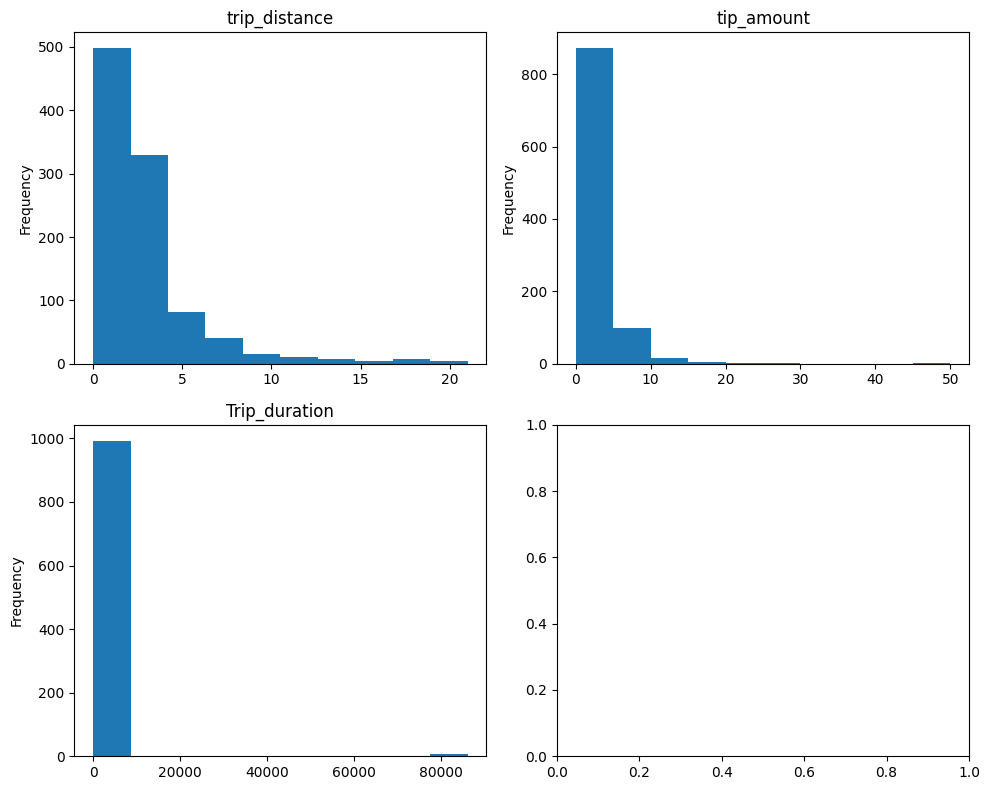

In [44]:
fig, axs = plt.subplots(2,2,figsize=(10, 8))
df['trip_distance'].plot(kind='hist', ax=axs[0, 0], title='trip_distance')
# df['passenger_count'].plot(kind='hist', ax=axs[1, 1], title='passenger_count')
df['tip_amount'].plot(kind='hist', ax=axs[0, 1], title='tip_amount')

# time
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
df['Trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds()
df['Trip_duration'].plot(kind='hist', ax=axs[1, 0], title='Trip_duration')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
new_columns = ['trip_distance', 'tip_amount', 'Trip_duration']
df_q = df[new_columns].copy()
df_q.describe()

,trip_distance,tip_amount,Trip_duration
count,1000.000000,1000.000000,1000.000000
mean,2.899540,2.384810,1282.657000
std,3.016125,3.640469,6807.559588
min,0.000000,0.000000,0.000000
25%,1.200000,0.000000,406.500000
50%,2.100000,1.940000,617.000000
75%,3.407500,3.480000,877.000000
max,21.000000,50.000000,86108.000000


## Result

partitions done
candidate set done
outliers done


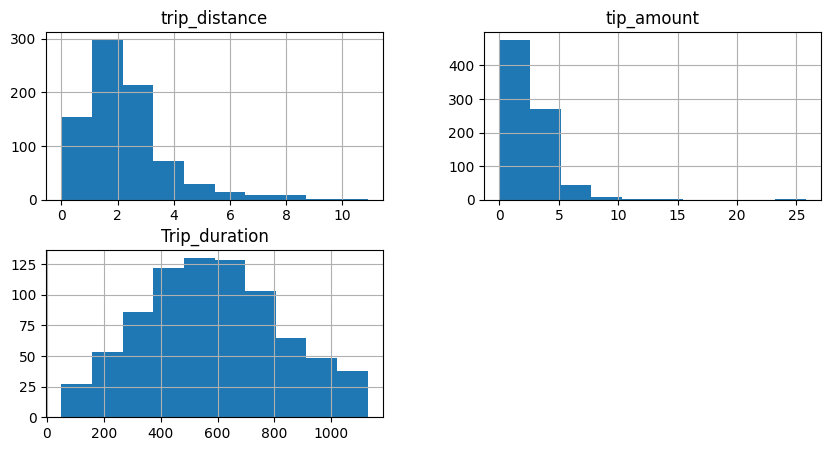

In [46]:
data = df_q.values.tolist()
# new_data = remove_outliers(data, 237, 500, 168)
new_data = remove_outliers(data,100, 200, 22)
df_new = pd.DataFrame(new_data,columns = ['trip_distance', 'tip_amount', 'Trip_duration'])
df_new.hist(figsize=(10, 5))
plt.show()
